# Wit 'n Wisdom 

Embedding graph of the Wit and Wisdoms of Poor Richard (A.K.A Benjamin Franklin)

## Why

While living in Philadelphia I was gifted the *Dover Thrift Editions* of *Wit & Wisdom From Poor Richard's Almanack*. This **thorughly** entertaining read made me curious regarding how much advice is just re-hashed from earlier sayings or the same phrase re-constructed. 

Working from the [Wikiquote of Poor Richard's Almanak](https://en.m.wikiquote.org/wiki/Poor_Richard%27s_Almanack), it is suprisingly difficult to find transcribed or uploaded copies of Poor Richard's Alamanck online, I transcribed the quotes and collected the year of the almanack in which it appeared.  

Working with Embedding was new for me. This [repo by ansonyuu](https://github.com/ansonyuu/matchmaking ) was well written and a great resource. While it was originally used to embed and visualize the interests of conference attendees, quotes by a dead founding father work just as well. 

In [2]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
#from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import umap

In [3]:
#import data
quotes = pd.read_csv('wit_and_wisdoms.csv')


# construct the sentence transformer
model = SentenceTransformer('all-MiniLM-L6-v2')
paragraphs = quotes['Quote'].tolist()
embeddings = model.encode(paragraphs)

# Scale and Reduce the data
reducer = umap.UMAP()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(embeddings))
reduce_data = reducer.fit_transform(scaled_data)

quotes['Dimension_1'] = reduce_data[:, 0].tolist()
quotes['Dimension_2'] = reduce_data[:, 1].tolist()


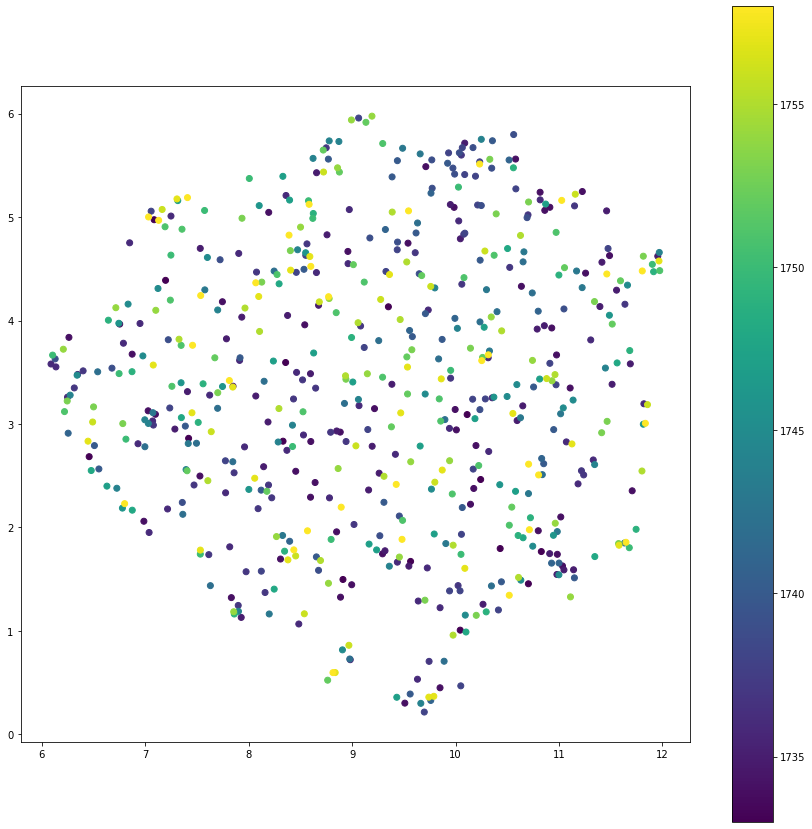

In [6]:
# Simple plot of data
plt.figure(figsize=(15, 15))
plt.scatter(quotes['Dimension_1'], quotes['Dimension_2'], c=quotes['Date'])
plt.colorbar().ax.tick_params(labelsize=10)
plt.gca().set_aspect('equal', adjustable='box')


Visually we can see some poorly defined clusters as well as multiple sets of near-overlapping points. The last two editions (1757 & 1758 in bright yellows) contain many sayings which are slight updatings or direct repeats from earlier editions. Check out the app version to select and highlight the different clusters.

# App Troubleshooting

What follows is a workspace for the Dash App version of this visualization. Rendering is easier in the notebook than in the app.py file.

In [ ]:
from dash import Dash, html, dcc, callback, Input, Output, State, dash_table
import plotly.express as px

import pandas as pd
from scipy import spatial
from sentence_transformers import SentenceTransformer
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, \
                                    MaxAbsScaler, QuantileTransformer, PowerTransformer, \
                                    Normalizer, Binarizer


# Refactor back to MVP and push to git. Then spend time on the choices.

#### Data Import
quotes = pd.read_csv('wit_and_wisdoms.csv')

# Data options for language model, reducer, scaler
# Make sure import statements reflect all options
language_model_choices = {'all-MiniLM-L6-v2': 'all-MiniLM-L6-v2',
                          'all-MiniLM-L12-v2': 'all-MiniLM-L12-v2',
                          'all-distilroberta-v1': 'all-distilroberta-v1',
                          'all-mpnet-base-v2': 'all-mpnet-base-v2',
                          'paraphrase-albert-small-v2': 'paraphrase-albert-small-v2',
                          'paraphrase-MiniLM-L3-v2' : 'paraphrase-MiniLM-L3-v2'}
reducer_choices =  {'UMAP': 'UMAP',
                    'PCA': 'PCA',
                    't-SNE':'t-SNE'}
scalers_choices = {'Standard Scaler':'StandardScaler',
                   'MinMax Scaler':'MinMaxScaler',
                   'Robust Scaler':'RobustScaler',
                   'Max Abs Scaler':'MaxAbsScaler',
                   'Quantile Transformer':'QuantileTransformer',
                   'Power Transformer':'PowerTransformer',
                   'Normalizer':'Normalizer',
                   'Binarizer':'Binarizer'}


# construct the sentence transformer
model = SentenceTransformer('all-MiniLM-L6-v2')
paragraphs = quotes['Quote'].tolist()
embeddings = model.encode(paragraphs)

# Scale and Reduce the data
reducer = umap.UMAP()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(embeddings))
reduce_data = reducer.fit_transform(scaled_data)

quotes['Dimension_1'] = reduce_data[:, 0].tolist()
quotes['Dimension_2'] = reduce_data[:, 1].tolist()
quotes['id'] = quotes.index

#### Dash Components
# Main Figure
fig = px.scatter(
            quotes,
            x="Dimension_1", 
            y="Dimension_2", 
            color="Date",
            color_continuous_scale = px.colors.sequential.Turbo,
            custom_data=['id'],
            labels={'Dimension_1': '', 'Dimension_2': ''},
            hover_name='Quote',
            hover_data={'Date': True, 'Dimension_1': False, 'Dimension_2': False},
            template='simple_white'
            ).update_layout(dragmode='select').update_xaxes(visible=False, showticklabels=False).update_yaxes(visible=False,showticklabels=False)

# Graph component of embedded quotes
graph_comp = dcc.Graph(
    id='scatter',
    figure = fig,
    config = {
        'modeBarButtonsToRemove': ['pan','autoScale','zoomIn','zoomOut'],
        'displaylogo': False}
    )

# Table showing selected data
table_comp = dash_table.DataTable(
            id='table-comp',
            columns=[{"name": i, "id": i} for i in quotes.columns if i in ['Quote', 'Date']],
            data = quotes.to_dict('records'),
            sort_action='native',
            style_cell={'textAlign': 'left'},
        ),

#### Dash App
app = Dash(__name__)

app.layout = html.Div([
    html.H1('Wit, Wisdom, & Weights'),
    html.H3('A Visual Exploration of Poor Richard\'s Almanack'),
    html.H5('Wit: James Welch \n Wisdom: Benjamin Franklin'),
    dcc.Markdown('''
                    From 1732 to 1758, Ben Franklin published "Poor Richard's Almanack," an influential publication \
                    filled with farming information, calendars, poems, and proverbs offering insights into human nature and morality.\
                    I was gifted a condensed guide with these proverbs grouped togeather by themes such as "Deceit and Trust", "Folly", and "Talking and Silence".\
                    I thought it would be interesting to group these sayings using vector embeddings and dimension reduction to generate visualizations of the groupings.
                 
                    I was inspired and guided by this [project from ansonyuu.](https://github.com/ansonyuu/matchmaking) \
                    Using the sentence-transformers library, the text is transformed into a large array. UMAP is then used to reduce the dimensions of the array to two.\
                    I found this [guide by StatQuest](https://youtu.be/eN0wFzBA4Sc) to be a useful introduction to the process.\
                    The result is an x and y value for each quote that represents its meaning and can be ploted. The clustering of \
                    the points should represent the similarity of the quotes. Color is added to represent the publishing date of the quote.
                 
                    Hover over the points to see the quote and date it was published. Click and drag to select points and view them in the table below.\
                    Double click to reset the view. Try entering a quote of your own to find the most similar quote in the dataset.
                 '''),
    html.Br(),
    #html.Div("Select a language model to use:"),
    #dcc.Dropdown(id='language_model', 
    #             options=language_model_choices, 
    #             value='all-MiniLM-L6-v2',
    #             style={'width': '50%'}),
    #html.Br(),
    # html.Div("Select a dimensionality reduction method to use:"),
    # dcc.Dropdown(id='reducer', 
    #              options=reducer_choices, 
    #              value='UMAP',
    #              style={'width': '50%'}),
    # html.Br(),
    # html.Div("Select a Scaling method to use:"),
    # dcc.Dropdown(id='scaler', 
    #              options=scalers_choices, 
    #              value='Standard Scaler',
    #              style={'width': '50%'}),
    # html.Br(),
    # html.Button(id='calc_data', 
    #             n_clicks=0, 
    #             children='Calculate Data'),
    #html.Br(),
    dcc.Markdown('''
                 ## Quote Similarity
                 Enter a quote of your own to find the most similar quote in the dataset.'''),
    dcc.Input(id='user_quote_input', type='text', value=''),
    html.Br(),    
    html.Div(id='quote-similarity'),
    html.Br(),
    graph_comp,
    html.Br(),
    html.Br(),
    html.Div(table_comp), 
    
])

#### Helper Functions [CURRENTLY UNIMPLEMENTED]
# Could use case-match in python 3.10+
# Ideally the object would be the key to the dropdown but it it isn't JSON serializable 

# def create_sentence_transformer(language_model):
#     try:
#         model = SentenceTransformer(language_model)
#     except ValueError:
#         ValueError('Language model not found, confirm package is installed.')
#     return model

# def create_reducer(reducer):
#     if reducer == 'UMAP':
#         reducer = umap.UMAP()
#     elif reducer == 'PCA':
#         reducer = PCA()
#     elif reducer == 't-SNE':
#         reducer = TSNE()
#     else:
#         ValueError('Reducer not found, confirm package is installed.')
#     return reducer

# def create_scaler(scaler):
#     if scaler == 'StandardScaler':
#         scaler = StandardScaler()
#     elif scaler == 'MinMaxScaler':
#         scaler = MinMaxScaler()
#     elif scaler == 'RobustScaler':
#         scaler = RobustScaler()
#     elif scaler == 'MaxAbsScaler':
#         scaler = MaxAbsScaler()
#     elif scaler == 'QuantileTransformer':
#         scaler = QuantileTransformer()
#     elif scaler == 'PowerTransformer':
#         scaler = PowerTransformer()
#     elif scaler == 'Normalizer':
#         scaler = Normalizer()
#     elif scaler == 'Binarizer':
#         scaler = Binarizer()
#     else:
#         ValueError('Scaler not found, confirm package is installed.')
#     return scaler



#### Callbacks [CURRENTLY UNIMPLEMENTED]
# @app.callback(Output('scatter', 'figure'),
#               Input('calc_data', 'n_clicks'), 
#               State('language_model','value'), 
#               State('reducer','value'),
#               State('scaler','value'))
# def recalculate_data(n_clicks, language_model, reducer, scaler):
#     print(n_clicks, language_model, reducer, scaler)

#     model = create_sentence_transformer(language_model)
#     reducer = create_reducer(reducer)
#     scaler = create_scaler(scaler)

#     # construct the sentence transformer
#     paragraphs = quotes['Quote'].tolist()
#     embeddings = model.encode(paragraphs)

#     # Scale and Reduce the data
#     scaled_data = scaler.fit_transform(list(embeddings))
#     reduce_data = reducer.fit_transform(scaled_data)

#     quotes['Dimension_1'] = reduce_data[:, 0].tolist()
#     quotes['Dimension_2'] = reduce_data[:, 1].tolist()
#     quotes['id'] = quotes.index

    
#     fig = px.scatter(
#         quotes,
#         x="Dimension_1", 
#         y="Dimension_2", 
#         color="Date",
#         custom_data=['id'],
#         labels={'Dimension_1': '', 'Dimension_2': ''},
#         hover_name='Quote',
#         hover_data={'Date': True, 'Dimension_1': False, 'Dimension_2': False}
#         ).update_layout(dragmode='select')
    
#     return fig

# need access to the model outside that first callback, run on initilization?
@app.callback(Output('quote-similarity', 'children'), Input('user_quote_input', 'value'))
def update_similarity(user_quote_input): 
    if user_quote_input:
        quote_embedding = model.encode(user_quote_input)
        similarities = 1 - spatial.distance.cdist([quote_embedding], scaled_data, "cosine")[0]
        most_similar = quotes.iloc[similarities.argmax()]
        return f'The most similar quote is: {most_similar["Quote"]}'
    else:
        return ' '
    
# Error here
@app.callback(Output('table-comp', 'data'), Input('scatter', 'selectedData'))
def update_table(selectedData):
    if selectedData is None:
        highlighted_id = []    
    else:
        highlighted_id = [point['customdata'][0] for point in selectedData['points']]    

    return quotes[quotes['id'].isin(highlighted_id)].to_dict('records')

if __name__ == '__main__':
    app.run_server(debug=True)